# DSA 210 Caffeine Consumption and the Effect of Exams on it.
This is the notebook for my project, here I will explain how my data was handled, and how I plotted the charts.

*For a detailed explanation of how my original data files were created and constructed please read the corresponding part on my presentation.*

Both of the original files were in .csv format, you may find them inside the project folder as "DSA210 Manually Logged Consumption" and "DSA210 Application Logged Consumption", please take a look at them to further understand the format.

Both files have a different format so I needed to run some code to prepare them for usage.

For the conversion of pieces of drinks to caffeine amounts, I have done some research through the internet and calculated the average caffeine content of the products. Unless it is a specially brewed or consturcted coffee most coffees of the same size have the same amount of espresso in them. The caffeine content of the drinks I have consumed were calculated and converted using the chart below:
|Drink/Size | Caffeine per Cup/Can (mg)|
|---|---|
|Mid Coffee(s)| 63|
|Large Coffee(s) | 126|
|Cortado | 126|
|Filter Coffee | 155|
|BlackEye | 281|
|RedEye | 218|
|Cold Brew | 200|
|Tea | 50|
|Energy Drink | 80|


Part 1: Converting the two differently logged data into caffeine

In [155]:
#converts the application data
import pandas as pd
import re

df = pd.read_csv("C:/Users/mabag/Desktop/DSA210 Application Logged Consumption.csv", sep=";")

#here we define caffeine values for the drinks
caffeine_map = {
    "Cortado": 126,
    "Filter": 155,
    "BlackEye": 281,
    "RedEye": 218,
    "ColdBrew": 200,
    "Mid": 63,
    "Large": 126
}

#this function returns the total amount of caffeine for that day
def parse_logged(entry):
    if pd.isna(entry):
        return 0
    total = 0
    for part in entry.split("-"):
        match = re.match(r"(\d+)\s(.+)", part.strip())
        if match:
            count = int(match.group(1))
            drink = match.group(2).strip()
            if drink in caffeine_map:
                total += count * caffeine_map[drink]
    return total

df["caffeine"] = df["Coffee"].apply(parse_logged)
df.drop(columns=["Coffee"], inplace=True)

#saving the data to a new file 
df.to_csv("C:/Users/mabag/Desktop/ApplicationCaffeine.csv", index=False, sep=";")

In [156]:
#converts the hand logged data
import pandas as pd

df = pd.read_csv("C:/Users/mabag/Desktop/DSA210 Manually Logged Consumption.csv", sep=',')

#caffeine calculation
df["caffeine"] = (
    df["tea"] * 50 +
    df["filter coffee"] * 155 +
    df["energy drink"] * 80
)

#we only keep the date and caffeine columns
df = df[["Date", "caffeine"]]

#saving the data to a new file 
df.to_csv("C:/Users/mabag/Desktop/ManualCaffeine.csv", index=False)


Part 2: Merging the two data and formattig the data

In [ ]:
import pandas as pd

df1 = pd.read_csv("C:/Users/mabag/Desktop/ApplicationCaffeine.csv", sep=";")
df2 = pd.read_csv("C:/Users/mabag/Desktop/ManualCaffeine.csv")

#merge dates
merged = pd.merge(df1, df2, on="Date", suffixes=("_desc", "_item"))

#getting the total caffeine
merged["Total Caffeine"] = merged["caffeine_desc"] + merged["caffeine_item"]
finalDf = merged[["Date", "Exam", "Total Caffeine"]]

#saving the data to a new file 
finalDf.to_csv("C:/Users/mabag/Desktop/MergedCaffeineData.csv", index=False)

In [158]:
import pandas as pd

mergedDF = pd.read_csv("C:/Users/mabag/Desktop/MergedCaffeineData.csv")

#converts the date into the format we want and converts the floats to integers
mergedDF["Date"] = pd.to_datetime(mergedDF["Date"], dayfirst=True) 
mergedDF["Total Caffeine"] = mergedDF["Total Caffeine"].round().astype(int)

#initialising columns
mergedDF["Within 1 Week Before Exam"] = 0
mergedDF["Within 3 Days Before Exam"] = 0
mergedDF["1 Day Before Exam"] = 0
mergedDF["On Exam Day"] = 0

#get the exam dates
examDates = mergedDF.loc[mergedDF["Exam"] == 1, "Date"].tolist()

#here we assign the proximity tag by looking at the days until an exam
for i, row in mergedDF.iterrows():
    currentDate = row["Date"]
    closestExam = None
    minDays = float("inf")

    #finds the closest exam(not before)
    for examDate in examDates:
        delta_days = (examDate - currentDate).days
        if 0 <= delta_days < minDays:
            minDays = delta_days
            closestExam = examDate

    #one-hot-like assigning based on remaining days to exam
    if minDays == 0:
        mergedDF.at[i, "On Exam Day"] = 1
    elif minDays == 1:
        mergedDF.at[i, "1 Day Before Exam"] = 1
    elif minDays in [2, 3]:
        mergedDF.at[i, "Within 3 Days Before Exam"] = 1
    elif 4 <= minDays <= 7:
        mergedDF.at[i, "Within 1 Week Before Exam"] = 1

#assigning the proximity level tags by looking at the one-hot-like encoding
def assignProximity(row):
    if row["On Exam Day"] == 1:
        return "On Exam Day"
    elif row["1 Day Before Exam"] == 1:
        return "1 Day Before Exam"
    elif row["Within 3 Days Before Exam"] == 1:
        return "Within 3 Days Before Exam"
    elif row["Within 1 Week Before Exam"] == 1:
        return "Within 1 Week Before Exam"
    else:
        return "Not Related to Exam"

mergedDF["Exam Proximity"] = mergedDF.apply(assignProximity, axis=1)
mergedDF["Exam Related"] = mergedDF["Exam Proximity"].apply(lambda x: "Related to Exam" if x != "Not Related to Exam" else "Not Related to Exam")

#formatting rhe final output
final = mergedDF[[
    "Date",
    "Within 1 Week Before Exam",
    "Within 3 Days Before Exam",
    "1 Day Before Exam",
    "On Exam Day",
    "Total Caffeine",
    "Exam Proximity",
    "Exam Related"
]].rename(columns={"Total Caffeine": "Caffeine Consumption"}).reset_index(drop=True)


final.to_csv("C:/Users/mabag/Desktop/FormattedExamCaffeineData.csv", index=False)

After we run the final code we should get our final data. With this data we can start working on inspecting it.

# Below here are the codes written to plot the graphs/tables.

In [159]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
#for the box plots
import seaborn as sns
#for t-test
import numpy as np
from scipy.stats import t
from scipy.stats import ttest_ind

In [ ]:
#loading the dataset
df = pd.read_csv("C:/Users/mabag/Desktop/FormattedExamCaffeineData.csv")
df["Date"] = pd.to_datetime(df["Date"])
df["Caffeine Consumption"] = pd.to_numeric(df["Caffeine Consumption"], errors="coerce").fillna(0)

In [161]:
df.groupby(["Exam Proximity"])["Caffeine Consumption"].mean()

Exam Proximity
1 Day Before Exam            207.857143
Not Related to Exam           92.962406
On Exam Day                  139.500000
Within 1 Week Before Exam    108.800000
Within 3 Days Before Exam    142.380952
Name: Caffeine Consumption, dtype: float64

In [162]:
df.groupby(["Exam Proximity"])["Caffeine Consumption"].median()

Exam Proximity
1 Day Before Exam            155.0
Not Related to Exam           63.0
On Exam Day                  126.0
Within 1 Week Before Exam     81.5
Within 3 Days Before Exam    150.0
Name: Caffeine Consumption, dtype: float64

In [163]:
df.groupby(["Exam Related"])["Caffeine Consumption"].mean()

Exam Related
Not Related to Exam     92.962406
Related to Exam        140.721519
Name: Caffeine Consumption, dtype: float64

In [164]:
df.groupby(["Exam Related"])["Caffeine Consumption"].median()

Exam Related
Not Related to Exam     63.0
Related to Exam        150.0
Name: Caffeine Consumption, dtype: float64

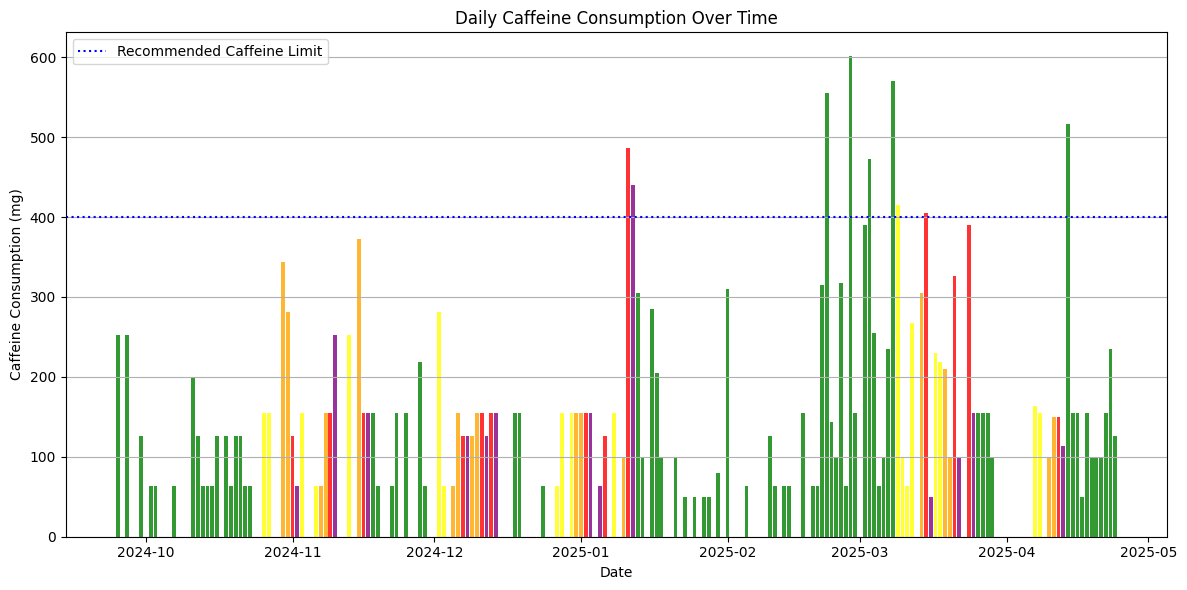

In [165]:
#code for the bar chart based on exam proximity

#defining the color map for exam proximities
colorMap = {
    "Not Related to Exam":"green",
    "Within 1 Week Before Exam":"yellow",
    "Within 3 Days Before Exam":"orange",
    "1 Day Before Exam":"red",
    "On Exam Day":"purple"
}

#adding a new column for color based on Exam Proximity
df["Color"] = df["Exam Proximity"].map(colorMap)

#plotting the caffeine consumption for each day with color coding
plt.figure(figsize=(12, 6))
bars = plt.bar(df["Date"], df["Caffeine Consumption"], color=df["Color"].values, alpha=0.8)

#adding title and labels to the figure
plt.title("Daily Caffeine Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Caffeine Consumption (mg)")

plt.axhline(y=400, color='b', linestyle=':')
plt.legend(["Recommended Caffeine Limit"], loc="upper left")
plt.grid(True, axis='y')
plt.xticks()
plt.tight_layout()
plt.show()


C:\Users\mabag\AppData\Local\Temp\ipykernel_25656\4157663886.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


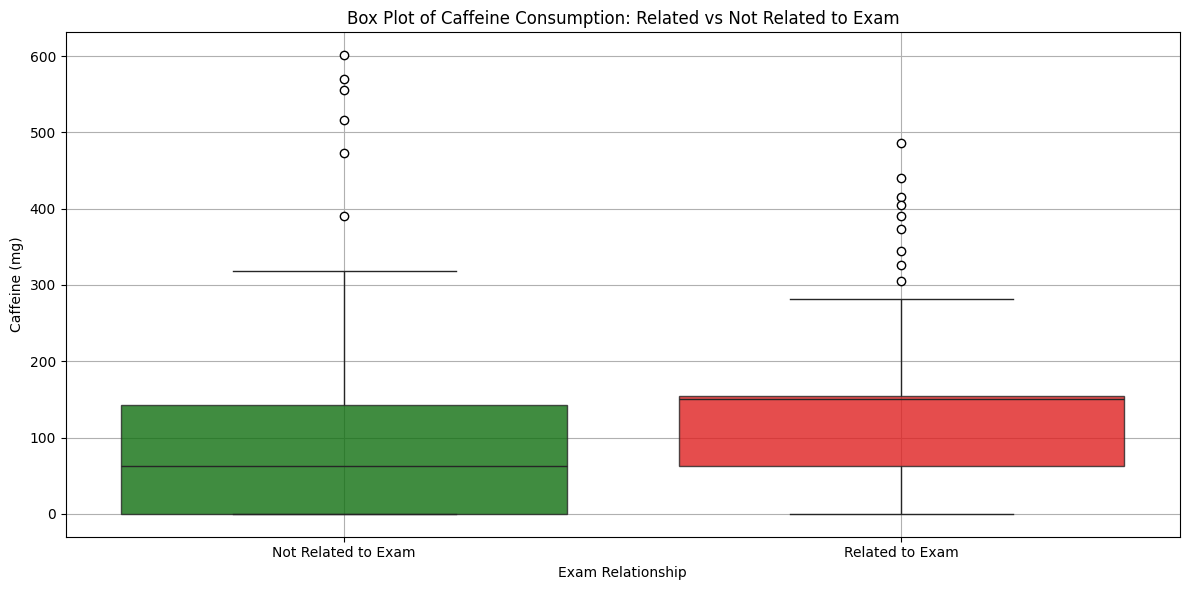

In [166]:
#code for the box-plot of the days in maximum 1 week proximity of an exam and days unrelated

colorMap = {
    "Not Related to Exam":"green",
    "Related to Exam":"red"
}

#plotting the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="Exam Related",
    y="Caffeine Consumption",
    flierprops=dict(marker="o", markerfacecolor="white", markeredgecolor="black", markersize=6, linestyle="none"),
    boxprops=dict(alpha= 0.8),
    palette= colorMap
)
plt.title("Box Plot of Caffeine Consumption: Related vs Not Related to Exam")
plt.xlabel("Exam Relationship")
plt.ylabel("Caffeine (mg)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [167]:
from scipy.stats import ttest_ind

NotRelated = df[df["Exam Related"] == 'Not Related to Exam']["Caffeine Consumption"]
related = df[df["Exam Related"] == 'Related to Exam']["Caffeine Consumption"]

tStat, pValue = ttest_ind(NotRelated, related, equal_var=False)

print("T-Statistic:", tStat,"\n" , "P Value:", pValue)


T-Statistic: -2.790345208227106 
 P Value: 0.005859627546978205


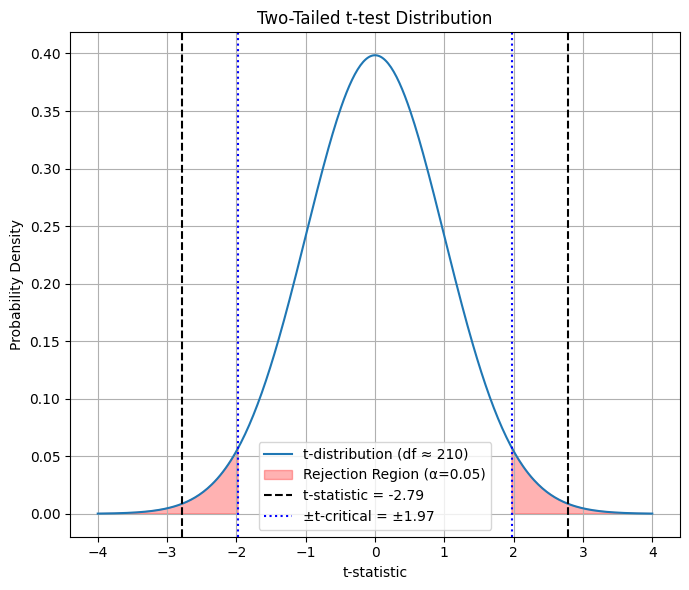

In [168]:
#code for the t-distribution

#generating values t distribution
x = np.linspace(-4, 4, 400)
y = t.pdf(x, 210)

alpha = 0.05
tCritical = t.ppf(1 - alpha / 2, 210)

#Plotting with critical t-values
plt.figure(figsize=(7, 6))
plt.plot(x, y, label=f"t-distribution (df ≈ {210})")
plt.fill_between(x, y, where=(x <= -tCritical) | (x >= tCritical), color="red", alpha=0.3, label="Rejection Region (α=0.05)")
plt.axvline(tStat, color="black", linestyle="--", label=f't-statistic = {tStat:.2f}')
plt.axvline(-tStat, color="black", linestyle="--")
plt.axvline(tCritical, color="blue", linestyle=":", label=f'±t-critical = ±{tCritical:.2f}')
plt.axvline(-tCritical, color="blue", linestyle=":")

plt.title("Two-Tailed t-test Distribution")
plt.xlabel("t-statistic")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [169]:
#code for calculating t-test of different proximities.

noRelation = df[df["Exam Proximity"] == 'Not Related to Exam']["Caffeine Consumption"]
oneWeek = df[df["Exam Proximity"] == "Within 1 Week Before Exam"]["Caffeine Consumption"]
threeDays = df[df["Exam Proximity"] == "Within 3 Days Before Exam"]["Caffeine Consumption"]
oneDay = df[df["Exam Proximity"] == "1 Day Before Exam"]["Caffeine Consumption"]
examDay = df[df["Exam Proximity"] == "On Exam Day"]["Caffeine Consumption"]


tStat1, pValue1 = ttest_ind(noRelation, oneWeek, equal_var=False)
print("T-Statistic:", tStat1,"\n" , "P Value:", pValue1)
print()
tStat2, pValue2 = ttest_ind(oneWeek, threeDays, equal_var=False)
print("T-Statistic:", tStat2,"\n" , "P Value:", pValue2)
print()
tStat3, pValue3 = ttest_ind(threeDays, oneDay, equal_var=False)
print("T-Statistic:", tStat3,"\n" , "P Value:", pValue3)
print()
tStat4, pValue4 = ttest_ind(oneDay, examDay, equal_var=False)
print("T-Statistic:", tStat4,"\n" , "P Value:", pValue4)


T-Statistic: -0.6926913220634389 
 P Value: 0.4918823043921825

T-Statistic: -1.0690586952907544 
 P Value: 0.2909897953430043

T-Statistic: -1.493435815567023 
 P Value: 0.1484557348654092

T-Statistic: 1.4772414591352112 
 P Value: 0.15237922521395125


C:\Users\mabag\AppData\Local\Temp\ipykernel_25656\1707146999.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


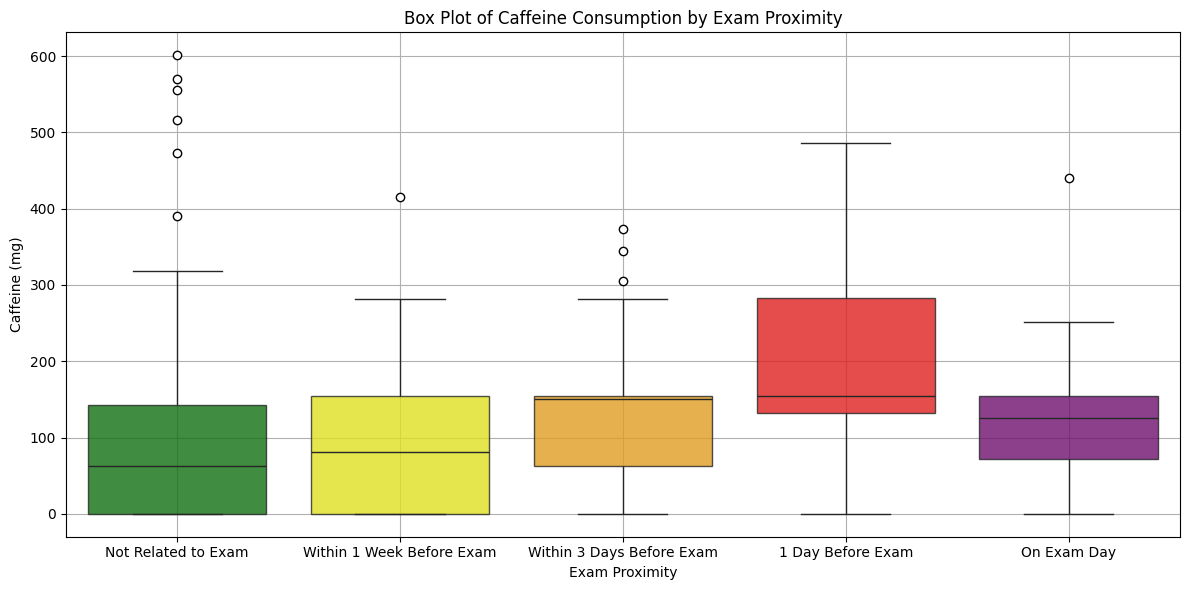

In [170]:
#code for the box plot of days with different proximity levels

#define color map for proximity levels
colorMap = {
    "Not Related to Exam":"green",
    "Within 1 Week Before Exam":"yellow",
    "Within 3 Days Before Exam":"orange",
    "1 Day Before Exam":"red",
    "On Exam Day":"purple"
}

#adding color based on exam proximity
df["Color"] = df["Exam Proximity"].map(colorMap)

#plotting the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="Exam Proximity",
    y="Caffeine Consumption",
    flierprops=dict(marker='o', markerfacecolor='white', markeredgecolor="black", markersize=6),
    boxprops=dict(alpha=0.8),
    palette= colorMap
)
plt.title("Box Plot of Caffeine Consumption by Exam Proximity")
plt.xlabel("Exam Proximity")
plt.ylabel("Caffeine (mg)")
plt.grid(True)
plt.tight_layout()
plt.show()